C:\Users\Ahmad Reza\AppData\Local\Temp\ipykernel_8068\342587960.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_path, parse_dates=['Dates'])
C:\Users\Ahmad Reza\AppData\Local\Temp\ipykernel_8068\342587960.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').mean()



=== Storage Contract Valuation ===
Net value: $-17177.44
Purchase cost: $231000.0
Sale revenue: $261822.56
Storage cost: $40000
Inj with cost: $8000.0
Months held: $8


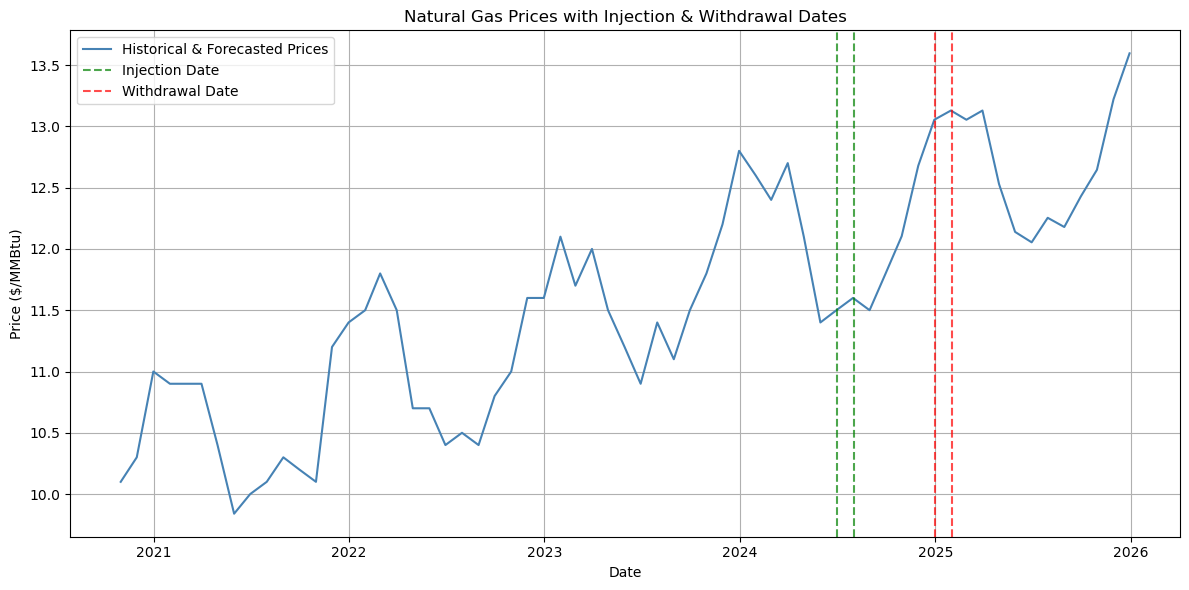

In [1]:
# J.P. Morgan Virtual Experience
# Task 2 – Price a Commodity Storage Contract
# Author: Ahmad Reza
# This script loads and forecasts natural gas prices,
# builds an interpolator, and prices a gas storage contract


import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# TASK 1: Load Data, Forecast, Create Interpolator 

def get_price_predictor(csv_path, forecast_months=15):
    df = pd.read_csv(csv_path, parse_dates=['Dates'])
    df.set_index('Dates', inplace=True)
    df = df.sort_index()

    # Monthly resample and interpolate missing values
    df = df.resample('M').mean()
    df['Prices'] = df['Prices'].interpolate()

    # Holt-Winters exponential smoothing model
    model = ExponentialSmoothing(df['Prices'], trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit()
    forecast = fit.forecast(forecast_months).astype(float)

    # Combine with future dates
    future_dates = [df.index[-1] + relativedelta(months=i+1) for i in range(forecast_months)]
    df_forecast = pd.DataFrame({'Prices': forecast.values}, index=future_dates)
    df_combined = pd.concat([df, df_forecast])
    df_combined = df_combined.reset_index().rename(columns={'index': 'Dates'})
    df_combined['Ordinal'] = df_combined['Dates'].map(datetime.toordinal)

    # Interpolator
    price_interp = interp1d(df_combined['Ordinal'], df_combined['Prices'], kind='linear', fill_value='extrapolate')

    def price_on_date(date):
        return float(price_interp(date.toordinal()))
    
    return price_on_date, df_combined

#  TASK 2: Storage Contract Pricing 

def price_storage_contract(
    injection_dates,
    withdrawal_dates,
    injection_volumes,
    withdrawal_volumes,
    price_fn,
    storage_cost_per_month,
    inj_with_cost_per_mmbtu,
    max_storage_volume
):
    assert len(injection_dates) == len(injection_volumes)
    assert len(withdrawal_dates) == len(withdrawal_volumes)

    total_injected = sum(injection_volumes)
    total_withdrawn = sum(withdrawal_volumes)

    if total_injected > max_storage_volume:
        raise ValueError("Total injected exceeds storage capacity.")
    if total_injected != total_withdrawn:
        raise ValueError("Injection and withdrawal volumes must match.")

    purchase_cost = sum(price_fn(date) * vol for date, vol in zip(injection_dates, injection_volumes))
    sale_revenue = sum(price_fn(date) * vol for date, vol in zip(withdrawal_dates, withdrawal_volumes))

    earliest = min(injection_dates)
    latest = max(withdrawal_dates)
    months_held = (latest.year - earliest.year) * 12 + (latest.month - earliest.month) + 1
    storage_cost = months_held * storage_cost_per_month
    inj_with_cost = inj_with_cost_per_mmbtu * (total_injected + total_withdrawn)

    net_value = sale_revenue - purchase_cost - storage_cost - inj_with_cost

    return {
        "net_value": round(net_value, 2),
        "purchase_cost": round(purchase_cost, 2),
        "sale_revenue": round(sale_revenue, 2),
        "storage_cost": round(storage_cost, 2),
        "inj_with_cost": round(inj_with_cost, 2),
        "months_held": months_held
    }

# Visualization 

def plot_prices_with_events(df_combined, injection_dates, withdrawal_dates):
    plt.figure(figsize=(12, 6))
    plt.plot(df_combined['Dates'], df_combined['Prices'], label='Historical & Forecasted Prices', color='steelblue')

    for d in injection_dates:
        plt.axvline(x=d, color='green', linestyle='--', alpha=0.7, label='Injection Date' if d == injection_dates[0] else "")
    for d in withdrawal_dates:
        plt.axvline(x=d, color='red', linestyle='--', alpha=0.7, label='Withdrawal Date' if d == withdrawal_dates[0] else "")

    plt.title("Natural Gas Prices with Injection & Withdrawal Dates")
    plt.xlabel("Date")
    plt.ylabel("Price ($/MMBtu)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Execution 

if __name__ == "__main__":
    csv_path = "E:\\J P Morgan Quantitative Research\\Nat_Gas.csv"

    # Get price function and full price timeline
    price_fn, df_combined = get_price_predictor(csv_path, forecast_months=15)

    # Define contract parameters
    injection_dates = [datetime(2024, 7, 1), datetime(2024, 8, 1)]
    withdrawal_dates = [datetime(2025, 1, 1), datetime(2025, 2, 1)]
    injection_volumes = [10000, 10000]
    withdrawal_volumes = [10000, 10000]

    storage_cost_per_month = 5000
    inj_with_cost_per_mmbtu = 0.2
    max_storage_volume = 30000

    # Run pricing model
    results = price_storage_contract(
        injection_dates,
        withdrawal_dates,
        injection_volumes,
        withdrawal_volumes,
        price_fn,
        storage_cost_per_month,
        inj_with_cost_per_mmbtu,
        max_storage_volume
    )

    # Print results
    print("\n=== Storage Contract Valuation ===")
    for key, value in results.items():
        print(f"{key.replace('_', ' ').capitalize()}: ${value}")

    # Plot
    plot_prices_with_events(df_combined, injection_dates, withdrawal_dates)
